In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import shap
from data.data_utils import *
from atl_utils import *

/opt/miniconda3/envs/atl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Looking at a model trained on all reactions

In [2]:
# Combining all datasets and preparing input, output arrays
sheet_names = ["Source", "Ala4MeBn", "ProIndan", "AlaIndan_ATL", "ProMex"]
X_desc_list = []
X_id_list = []
y_list = []

for sheet in sheet_names :
    X_source_id = pd.read_excel("./data/reaction_data.xlsx", sheet_name=sheet).iloc[:, 1:-2].to_numpy()
    X_source_desc = id_array_to_desc_array(X_source_id, True)
    y = pd.read_excel("./data/reaction_data.xlsx", sheet_name=sheet).iloc[:, -1].to_numpy()
    X_desc_list.append(X_source_desc)
    X_id_list.append(X_source_id)
    y_list.append(y)

X_desc = np.vstack(tuple(X_desc_list))
X_id = np.vstack(tuple(X_id_list))
y = np.concatenate(tuple(y_list))

print(X_desc.shape, y.shape)

(284, 58) (284,)


In [3]:
# Preparing descriptor names for interpretation
NHPI_desc = pd.read_excel(
    "./data/descriptors.xlsx",
    sheet_name="NHPI",
).columns.tolist()[2:]
NHPI_desc = ["NHPI_"+x for x in NHPI_desc]

Kat_desc = pd.read_excel(
    "./data/descriptors.xlsx",
    sheet_name="Katritzky",
).columns.tolist()[2:]
kat_desc = ["Kat_"+x for x in Kat_desc]

Ni_desc = ["NiCl2•dme", "NiBr2•dme", "NiI2", "Ni(COD)2", "Ni(acac)2"]

ligand_desc = pd.read_excel(
    "./data/descriptors.xlsx",
    sheet_name="Ligands",
    usecols=[3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18],
).columns.tolist()
ligand_desc = ["L_" + x for x in ligand_desc]

additives = ["Cl-", "Br-", "I-", "Li+", "Na+", "Mg2+", "K+", "Zn", "Succinimide", "TMS", "TBA"]

solvent_desc = ["Sol_HansenD", "Sol_HansenP", "Sol_HansenH", "Sol_AbrahamVx", "Sol_Dipole", "Sol_Refractive"]

desc_names = NHPI_desc + kat_desc + Ni_desc + ligand_desc + additives + solvent_desc
print(len(desc_names))

58


In [4]:
y_class = []
for i, y_val in enumerate(y) :
    if i < 71 :
        if y_val >= 60 :
            y_class.append(1)
        else :
            y_class.append(0)
    elif i < 83 :
        if y_val >= 9 :
            y_class.append(1)
        else : 
            y_class.append(0)
    elif i < 163 : 
        if y_val >= 7:
            y_class.append(1)
        else : 
            y_class.append(0)

    elif i < 163 + 13 : 
        if y_val >= 55 :
            y_class.append(1)
        else :
            y_class.append(0)
    elif i < 163 + 13 + 18 :
        if y_val >= 9 :
            y_class.append(1)
        else :
            y_class.append(0)
    else :
        if y_val >= 7 :
            y_class.append(1)
        else :
            y_class.append(0)
y_class = np.array(y_class)

In [5]:
# Define CV-folds by substrate pairs
subs_pairs = np.unique(X_id[:, :2], axis=0)
folds = [np.where(np.all(row == subs_pairs, axis=1))[0][0] for row in X_id[:, :2]]
ps = PredefinedSplit(folds)

# Train a model
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators":[5, 10, 25, 100],
    "max_depth":[1, 3, 5, None]
}
gcv = GridSearchCV(
    rfc,
    param_grid=param_grid,
    scoring="roc_auc",
    cv = ps.split()
)
gcv.fit(X_desc, y_class)

print(gcv.best_params_)
print(gcv.best_score_)

{'max_depth': 5, 'n_estimators': 100}
0.8363815124933545


PermutationExplainer explainer: 285it [00:27,  6.87it/s]                         


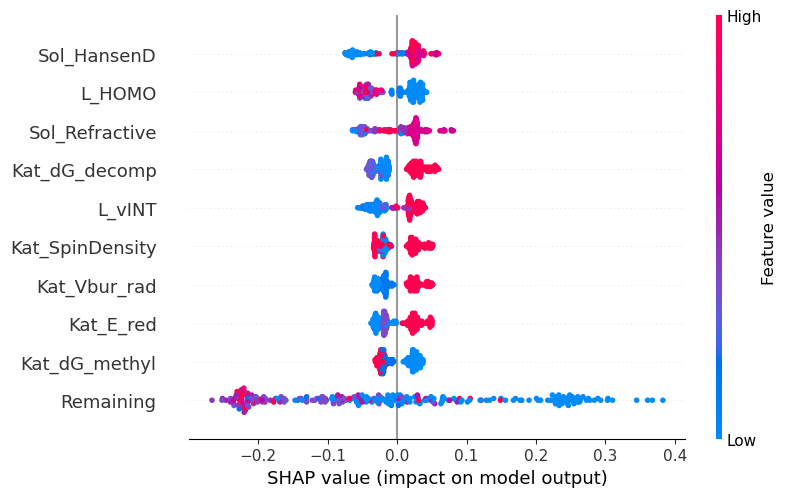

In [6]:
def f(x) :
    return gcv.best_estimator_.predict_proba(x)[:, 1]
explainer = shap.Explainer(f, X_desc)
shap_values = explainer(X_desc)
ax = shap.plots.beeswarm(shap_values, show=False) #group_remaining_features=False,  order=shap_values[:, :, 1].abs.max(0), 
ytl = [x.get_text() for x in ax.get_yticklabels()]
updated_ytl = ["Remaining"] +[desc_names[int(x.split()[-1])] for x in ytl[1:]]
ax.set_yticklabels(updated_ytl)
plt.savefig("FigureS19.svg", format="svg", dpi=300)
plt.show()

## Looking at a model trained on only Pro-Mex data

In [7]:
X_desc_promex = X_desc_list[-1]
X_id_promex = X_id_list[-1]
y_promex =  y_class[-72:]

# Defining CV-folds by additives
additive_pairs = np.unique(X_id[:, -3:-1], axis=0)
folds = [np.where(np.all(row == additive_pairs, axis=1))[0][0] for row in X_id_promex[:, -3:-1]]
ps = PredefinedSplit(folds)

# Train a model
rfr = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators":[5, 10, 25, 100],
    "max_depth":[1, 3, 5, None]
}
gcv = GridSearchCV(
    rfr,
    param_grid=param_grid,
    scoring="roc_auc",
    cv = 6
)
gcv.fit(X_desc_promex, y_promex)

GridSearchCV(cv=6, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 3, 5, None],
                         'n_estimators': [5, 10, 25, 100]},
             scoring='roc_auc')

In [8]:
print(gcv.best_params_)
print(gcv.best_score_)

{'max_depth': 3, 'n_estimators': 10}
0.8671296296296296


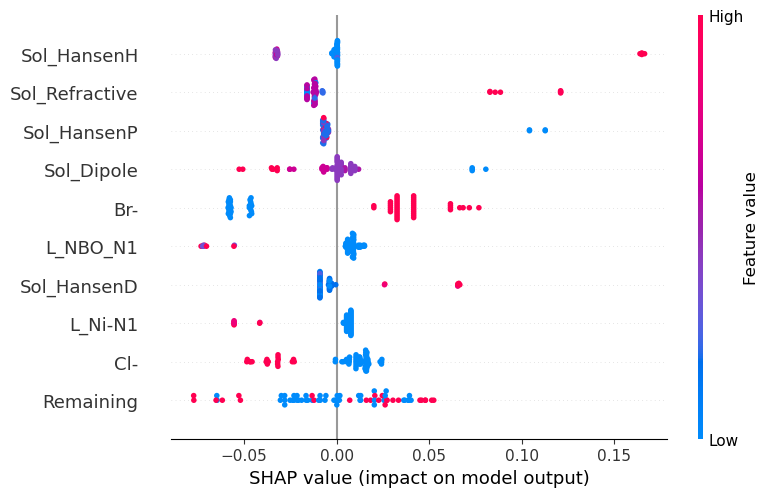

In [9]:
def f(x) :
    return gcv.best_estimator_.predict_proba(x)[:, 1]
explainer = shap.Explainer(f, X_desc_promex)
shap_values = explainer(X_desc_promex)
ax = shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), show=False) #group_remaining_features=False, 
ytl = [x.get_text() for x in ax.get_yticklabels()]
updated_ytl = ["Remaining"] +[desc_names[int(x.split()[-1])] for x in ytl[1:]]
ax.set_yticklabels(updated_ytl)
plt.savefig("FigureS20.svg", format="svg", dpi=300)
plt.show()

## Looking at a model trained on only Ala-Indan data

In [10]:
X_desc_alaind = np.vstack((X_desc_list[0][83:], X_desc_list[-2]))
X_id_alaind = np.vstack((X_id_list[0][83:], X_id_list[-2]))
y_alaind =  np.concatenate((y_list[0][83:], y_list[-2]))
assert np.unique(X_id_alaind[:, 0])[0] == 2
assert np.unique(X_id_alaind[:, 1])[0] == 2
from sklearn.preprocessing import binarize

y_alaind = binarize(y_alaind.reshape(-1, 1), threshold=6.99)

# Train a model
rfr = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators":[5, 10, 25, 100],
    "max_depth":[1, 3, 5, None]
}
gcv = GridSearchCV(
    rfr,
    param_grid=param_grid,
    scoring="roc_auc",
    cv = 6 #ps.split()
)
gcv.fit(X_desc_alaind, y_alaind.flatten())

GridSearchCV(cv=6, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 3, 5, None],
                         'n_estimators': [5, 10, 25, 100]},
             scoring='roc_auc')

In [11]:
print(gcv.best_params_)
print(gcv.best_score_)

{'max_depth': None, 'n_estimators': 25}
0.7557870370370371


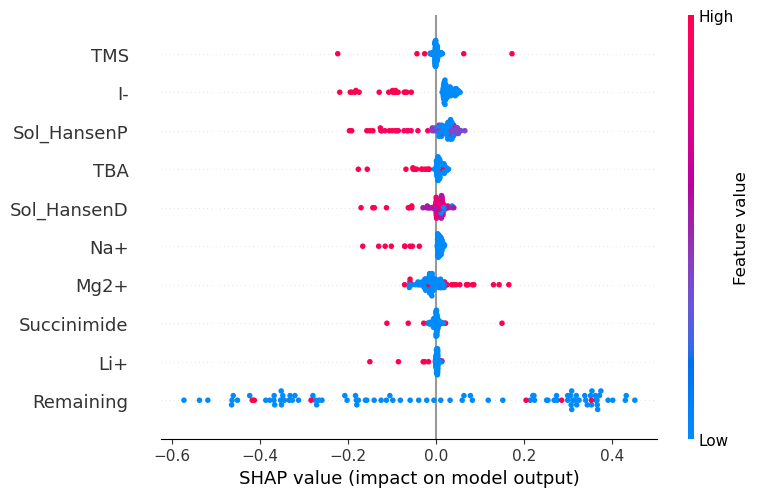

In [12]:
explainer = shap.Explainer(f, X_desc_alaind)
shap_values = explainer(X_desc_alaind)

ax = shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), show=False) #group_remaining_features=False, 
ytl = [x.get_text() for x in ax.get_yticklabels()]
updated_ytl = ["Remaining"] +[desc_names[int(x.split()[-1])] for x in ytl[1:]]
ax.set_yticklabels(updated_ytl)
plt.savefig("FigureS21.svg", format="svg", dpi=300)
plt.show()